In [2]:
import csv
ori_file_path = './benchmark_results.csv'
ori_models_list = ["784_56_10", "196_25_10", "196_24_14_10", "28_6_16_10_5", "14_5_11_80_10_3", "28_6_16_120_84_10_5"]

In [47]:
import pandas as pd


# Read the CSV file into a pandas DataFrame
df = pd.read_csv(ori_file_path)

# Check if the DataFrame needs filtering to exclude rows with "Combined" in the "Notes" column
df = df[~df['Notes'].str.contains('Combined', na=False)]

# Calculate the total proving time cost for each row
df['Total Proving Time (s)'] = df['Testing Size'] * df['Avg Proving Time (s)']

# Sum the 'Total Proving Time (s)' column
total_proving_time_seconds = df['Total Proving Time (s)'].sum()

# Convert the total proving time from seconds to minutes and hours
total_proving_time_minutes = total_proving_time_seconds / 60
total_proving_time_hours = total_proving_time_minutes / 60

# Output the total proving time in minutes and hours
print(f"Total Proving Time: {total_proving_time_seconds:.2f} seconds")
print(f"Total Proving Time: {total_proving_time_minutes:.2f} minutes")
print(f"Total Proving Time: {total_proving_time_hours:.2f} hours")



Total Proving Time: 790943.12 seconds
Total Proving Time: 13182.39 minutes
Total Proving Time: 219.71 hours


## Prepare

In [55]:
def read_data_for_architectures(file_path, target_architectures):
    # Ensure target_architectures is a list for uniform processing
    if isinstance(target_architectures, str):
        target_architectures = [target_architectures]

    results = {arch: {} for arch in target_architectures}

    with open(file_path, mode='r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        
        for row in reader:

            framework = row['Framework'].split(' ')[0]
            #print (framework)
            #frameworks.append(framework)
            architecture = row['Architecture']
            notes = row['Notes']
            #print (notes)

            if 'accuracy' in notes:
                framework += f' (accuracy)'
            elif 'resource' in notes:
                framework += f' (resource)'
            
            for target_arch in target_architectures:
                if architecture.lower() == target_arch.lower():
                    # This line ensures the last matching entry for each framework is kept
                    results[target_arch][framework] = [
                        row['Accuracy Loss (%)'],
                        row['Avg Memory Usage (MB)'],
                        row['Std Memory Usage'],
                        row['Avg Proving Time (s)'],
                        row['Std Proving Time']
                    ]
    
    return results


In [14]:
def target_arch(model_name):
    layers = model_name.split("_")
    if int(layers[0]) < 30:
        arch = "Input-Conv2d-Conv2d" + (len(layers)-4) * "-Dense" + "_Kernal"
        layers[0] = str(int(layers[0])**2)
        target = f'{arch} ({"x".join(layers[:-1])}_{layers[-1]}x{layers[-1]})'
    else:
        layers = model_name.split("_")
        arch = "Input" + (len(layers)-1) * "-Dense"
        target = f'{arch} ({"x".join(layers)})'
    
    return target

### Combine benchmark results

In [15]:
def read_and_combine_data(file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    #print ('Header:', df.head())

    # Group data by Framework and Architecture for processing
    grouped = df.groupby(['Framework', 'Architecture'])
    #print (grouped)
    
    for (framework, architecture), group in grouped:
        if len(group) == 2:  # Expecting two entries per group for combination
            base = group.iloc[0]
            follow_up = group.iloc[1]
            
            # Ensure we start with the base and follow up in the correct order
            if "start from 1000" in str(follow_up['Notes']):
                base, follow_up = follow_up, base  # Swap if in wrong order
            
            combined = base.copy()
            n1, n2 = 1000, 1500
            combined['Testing Size'] = 2500
            
            # Combine the metrics
            for metric in ['Accuracy Loss (%)', 'Avg Memory Usage (MB)', 'Avg Proving Time (s)']:
                combined[metric] = (n1 * base[metric] + n2 * follow_up[metric]) / (n1 + n2)
                
            for metric in ['Std Memory Usage', 'Std Proving Time']:
                # Placeholder for standard deviation combination, here we simply copy from follow_up
                # In reality, you should calculate combined standard deviation using a proper statistical method
                combined[metric] = follow_up[metric]
                

            combined['Notes'] = "Combined 0-2500"
            combined = combined.to_dict()
            for key in combined:
                combined[key] = [combined[key]]

            new_row_df = pd.DataFrame(combined)
            df = pd.concat([df, new_row_df], ignore_index=True)

    df.to_csv(file_path, index=False)

## Analysis

In [16]:
def extract(data, architectures):
    frameworks = list(data[architectures[0]].keys())

    memory_usage = {arch: [] for arch in architectures}
    accuracy_loss = {arch: [] for arch in architectures}
    proving_time = {arch: [] for arch in architectures}

    # Iterate over the original data to populate the new structures
    for arch, fw_data in data.items():
        for fw in frameworks:
            # Append memory usage and proving time to the respective dictionaries
            # Convert string values to float for numerical processing
            accuracy_loss[arch].append(float(fw_data[fw][0]))
            memory_usage[arch].append(float(fw_data[fw][1]))
            proving_time[arch].append(float(fw_data[fw][3]))

            if not fw_data[fw]:
                print ('should be the last', len(accuracy_loss[arch]))
                a = max(accuracy_loss[arch])
                b = max(memory_usage[arch])
                c = max(proving_time[arch])
                continue

    return frameworks, accuracy_loss, memory_usage, proving_time

def normalize(data):
    """Normalize the data so that lower values result in higher normalized scores.
    A lower original value results in a normalized value closer to 1."""
    min_val = min(data)
    max_val = max(data)
    # Invert the normalization: The best (lowest) value gets a score of 1, and the worst (highest) value gets a score of 0.
    return [(max_val - x) / (max_val - min_val) if max_val - min_val else 1 for x in data]


In [17]:
import matplotlib.pyplot as plt
import numpy as np
def plot_bar(archs, frameworks, accuracy_loss, memory_usage, proving_time):
    fig, ax = plt.subplots(1, 3, figsize=(21, 6))  # Adjusted for 3 subplots

    # Plotting Accuracy Loss
    for i, arch in enumerate(archs):
        indices = np.arange(len(frameworks))
        ax[0].bar(indices + i*0.3, accuracy_loss[arch], width=0.3, label=arch)

    ax[0].set_title('Accuracy Loss (%)')
    ax[0].set_xticks(indices + 0.3 / 2)
    ax[0].set_xticklabels(frameworks)
    ax[0].legend(title="Architecture")
    ax[0].set_ylabel('Accuracy Loss (%)')

    # Plotting Memory Usage
    for i, arch in enumerate(archs):
        indices = np.arange(len(frameworks))
        ax[1].bar(indices + i*0.3, memory_usage[arch], width=0.3, label=arch)

    ax[1].set_title('Average Memory Usage (MB)')
    ax[1].set_xticks(indices + 0.3 / 2)
    ax[1].set_xticklabels(frameworks)
    ax[1].legend(title="Architecture")
    ax[1].set_ylabel('Memory Usage (MB)')

    # Plotting Proving Time
    for i, arch in enumerate(archs):
        indices = np.arange(len(frameworks))
        ax[2].bar(indices + i*0.3, proving_time[arch], width=0.3, label=arch)

    ax[2].set_title('Average Proving Time (s)')
    ax[2].set_xticks(indices + 0.3 / 2)
    ax[2].set_xticklabels(frameworks)
    ax[2].legend(title="Architecture")
    ax[2].set_ylabel('Proving Time (s)')

    plt.tight_layout()
    plt.show()


In [18]:
def prepare_radar_data(archs, frameworks, accuracy_loss, memory_usage, proving_time):
    # Normalize the data
    normalized_memory_usage = {arch: normalize(values) for arch, values in memory_usage.items()}
    normalized_proving_time = {arch: normalize(values) for arch, values in proving_time.items()}
    normalized_accuracy_loss = {arch: normalize(values) for arch, values in accuracy_loss.items()}
    
    # Prepare the transition data and calculate sums
    transition_data = {}
    sums_per_arch = {arch: {} for arch in archs}  # Stores the sum of scores for each framework per architecture

    for fw in frameworks:
        transition_data[fw] = []
        for arch in archs:
            # Extract the normalized scores for the current framework and architecture
            accu_score = normalized_accuracy_loss[arch][frameworks.index(fw)]
            mem_score = normalized_memory_usage[arch][frameworks.index(fw)]
            time_score = normalized_proving_time[arch][frameworks.index(fw)]
            
            # Append the 3-dimensional vector
            transition_data[fw].append((accu_score, mem_score, time_score))
            
            # Calculate the sum of normalized scores
            sum_scores = accu_score + mem_score + time_score
            sums_per_arch[arch][fw] = sum_scores

    # Rank frameworks for each architecture based on the sum of scores
    ranks_per_arch = {}
    for arch in archs:
        # Sort frameworks based on sum of scores, higher is better
        ranked_frameworks = sorted(sums_per_arch[arch].items(), key=lambda x: x[1], reverse=True)
        ranks_per_arch[arch] = ranked_frameworks

    # Output the transition vectors and sum of scores for each framework, and their ranks
    # for fw, vectors in transition_data.items():
    #     print(f"{fw} transitions:")
    #     for i, arch in enumerate(archs):
    #         print(f"  {arch}: {vectors[i]}, Sum of scores: {sums_per_arch[arch][fw]}")
    #     print()

    # Output ranks for each architecture
    for arch, ranks in ranks_per_arch.items():
        print(f"Ranking for {arch}:")
        for rank, (fw, score) in enumerate(ranks, start=1):
            print(f"  {rank}. {fw} with a score of {score}")
        print()

    return transition_data


In [19]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines
def plot_radar_trans(archs, transition_data):
    # Metrics
    metrics = ['Accuracy Loss', 'Memory Usage', 'Proving Time']

    # Prepare the plot
    num_vars = len(metrics)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Complete the loop
    
    # Create a figure
    fig, axs = plt.subplots(figsize=(10, 10), nrows=2, ncols=2, subplot_kw=dict(polar=True))
    axs = axs.flatten()  # Flatten to easily iterate over

    # Assuming 'transition_data', 'metrics', 'archs' are defined as before

    for ax, (fw, vectors) in zip(axs, transition_data.items()):
        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)
        
        # Draw one axe per variable + add labels if needed
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(metrics)
        
        # Plot each transition for the framework, without adding a legend here
        for i, vector in enumerate(vectors):
            data = np.array(vector + vector[:1])  # Repeat the first value at the end to close the loop
            ax.plot(angles, data, 'o-', linewidth=2)
            ax.fill(angles, data, alpha=0.25)
        
        ax.set_title(fw)

    # Create custom legend entries
    legend_elements = [mlines.Line2D([], [], color='blue', marker='o', linestyle='-', linewidth=2, label=archs[0]),
                    mlines.Line2D([], [], color='orange', marker='o', linestyle='-', linewidth=2, label=archs[1])]

    # Place a single legend outside the subplots
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

    plt.tight_layout()
    plt.show()

In [20]:
def plot_radar_arch(transition_data, arch, archs):
    index = archs.index(arch)
    # Metrics
    metrics = ['Accuracy Loss', 'Memory Usage', 'Proving Time']

    # Number of variables we're plotting
    num_vars = len(metrics)

    # Split the circle into even parts and save angles so we know where to put each axis.
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The radar chart plot needs to be a closed circle, so we need to append the start value to the end.
    angles += angles[:1]

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    # Draw one axe per variable and add labels
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), metrics)

    # Draw y-labels (optionally adjust the range based on your scores)
    ax.set_rlabel_position(0)
    ax.set_ylim(0, 1)

    for fw, vectors in transition_data.items():
        values = vectors[index]
        # Radar chart plot needs to be a closed loop, so we need to append the start value to the end.
        values += values[:1]

        
        ax.plot(angles, values, label=fw)
        ax.fill(angles, values, alpha=0.1)

    plt.title(f'Framework Performance Comparison\nArchitecture: {arch}')
    # Add legend
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 0.1))

    plt.show()


### Varing Num of Layer in DNN

In [57]:
architectures = [target_arch(ori_models_list[1]), target_arch(ori_models_list[2])]
data = read_data_for_architectures('./benchmark_results.csv', architectures)
#frameworks, accuracy_loss, memory_usage, proving_time = extract(data, architectures)


In [58]:
data

{'Input-Dense-Dense (196x25x10)': {'opml': ['3.4000000000000004',
   '72.0850109375',
   '3.6633336331398594',
   '0.7951358239173889',
   '0.0685262991938739'],
  'circomlib-ml': ['0.0',
   '998.735128125',
   '8.040169563463648',
   '1.1694816182136536',
   '0.1084907231971162'],
  'zkml': ['0.06',
   '2331.704791927083',
   '12.335300742362184',
   '20.99934337067604',
   '0.294183256688111'],
  'ezkl (accuracy)': ['0.02666666666666664',
   '2616.87932265625',
   '1081.227781953129',
   '19.14905614344279',
   '8.710526377897478'],
  'ezkl (resource)': ['4.52',
   '91.0270125',
   '0.7484670755336666',
   '0.6538142914772034',
   '0.0263913837436752']},
 'Input-Dense-Dense-Dense (196x24x14x10)': {'opml': ['3.56',
   '70.3474296875',
   '1.9051222055836032',
   '0.8154945695877075',
   '0.0697695641586575'],
  'circomlib-ml': ['0.88',
   '315.435559375',
   '1.6906806598040391',
   '0.4529416603088378',
   '0.0316126449468401'],
  'zkml': ['0.0',
   '2338.480846875',
   '13.611456038

In [59]:
frameworks, accuracy_loss, memory_usage, proving_time = extract(data, architectures)

KeyError: 'ezkl (accuracy)'

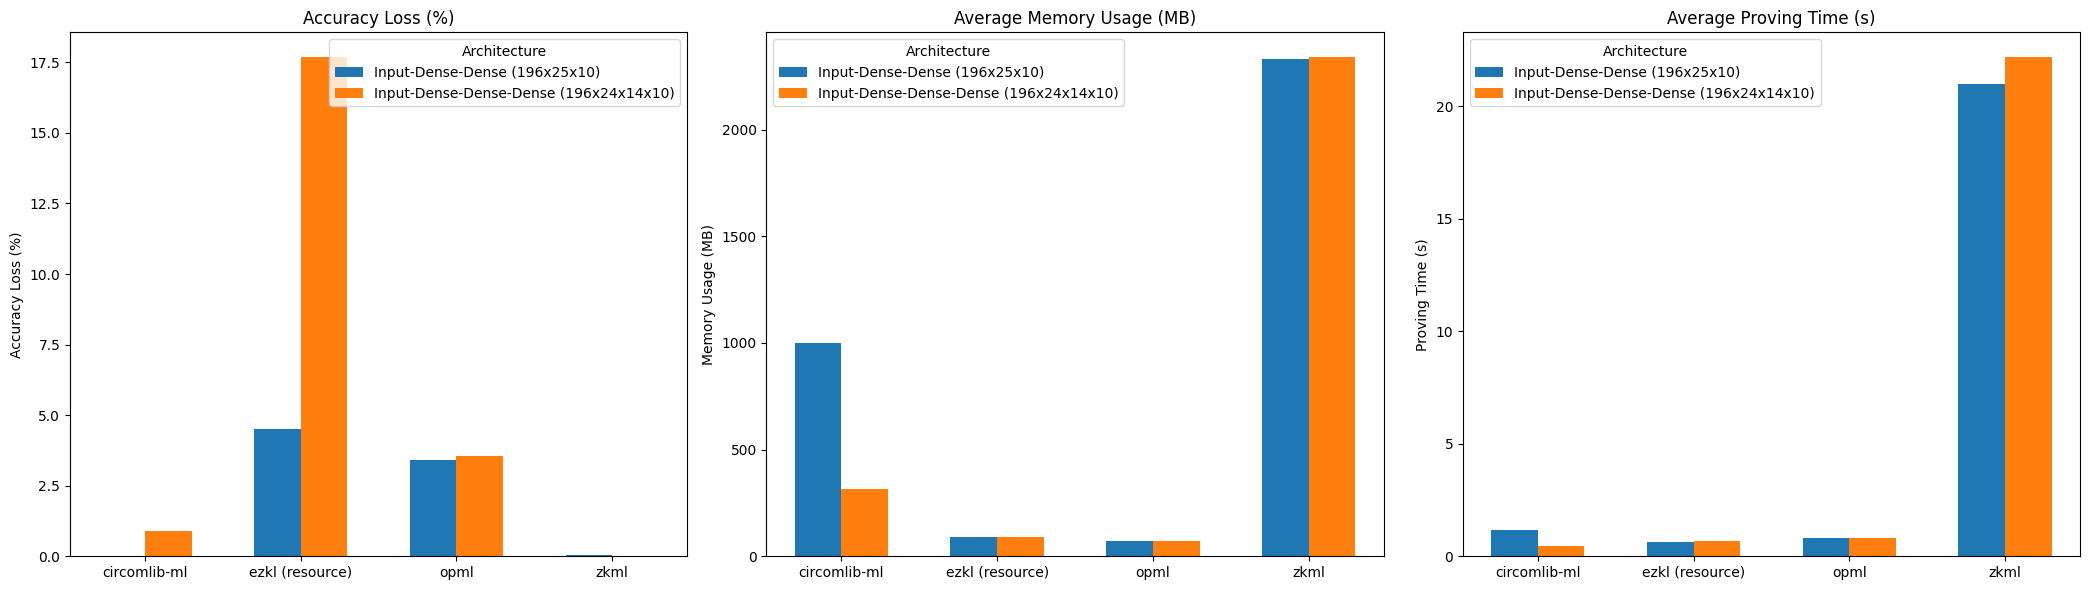

In [49]:
plot_bar(architectures, frameworks, accuracy_loss, memory_usage, proving_time)

In [50]:
transition_data = prepare_radar_data(architectures, frameworks, accuracy_loss, memory_usage, proving_time)

Ranking for Input-Dense-Dense (196x25x10):
  1. circomlib-ml with a score of 2.564563344918927
  2. opml with a score of 2.240841537509742
  3. ezkl (resource) with a score of 1.991617173065194
  4. zkml with a score of 0.9867256637168142

Ranking for Input-Dense-Dense-Dense (196x24x14x10):
  1. circomlib-ml with a score of 2.842169051662779
  2. opml with a score of 2.781947028741266
  3. ezkl (resource) with a score of 1.980167323129606
  4. zkml with a score of 1.0



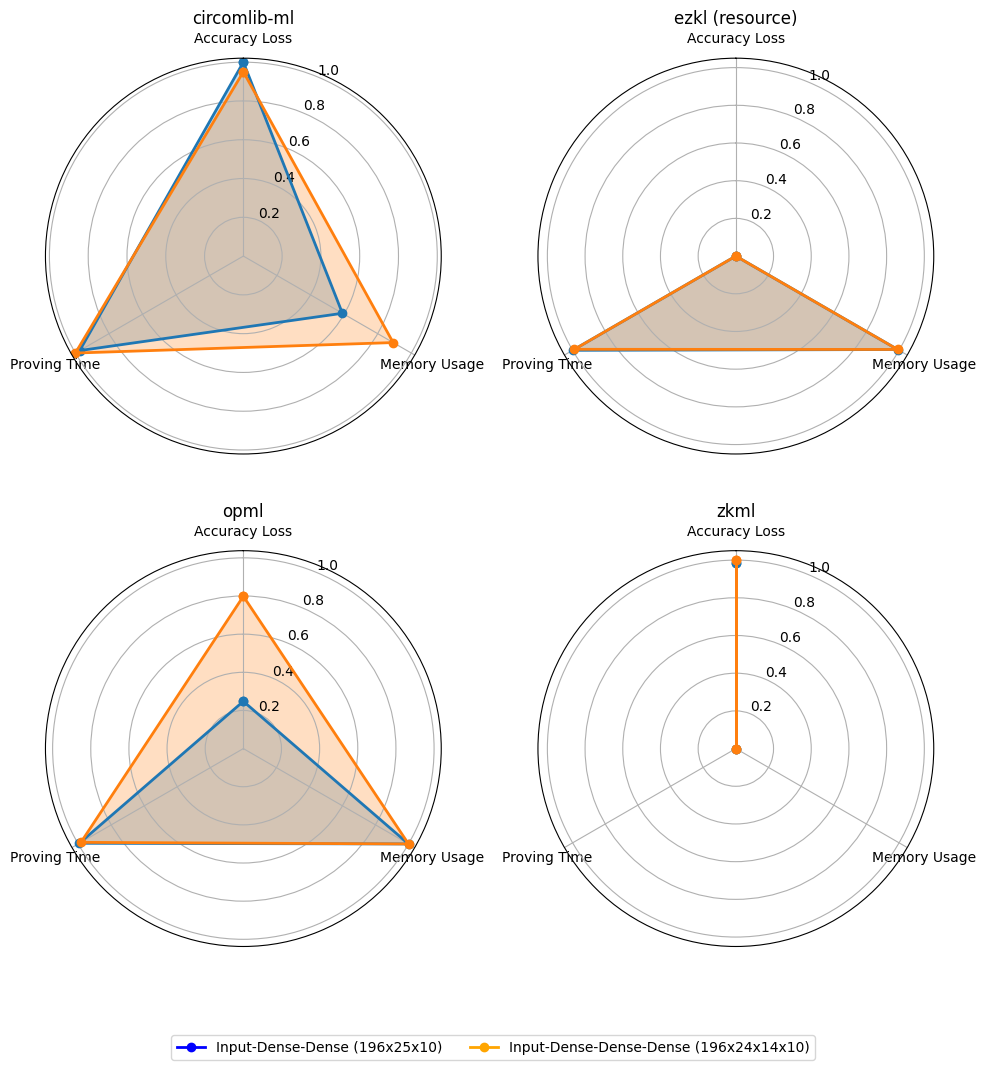

In [51]:
plot_radar_trans(architectures, transition_data)

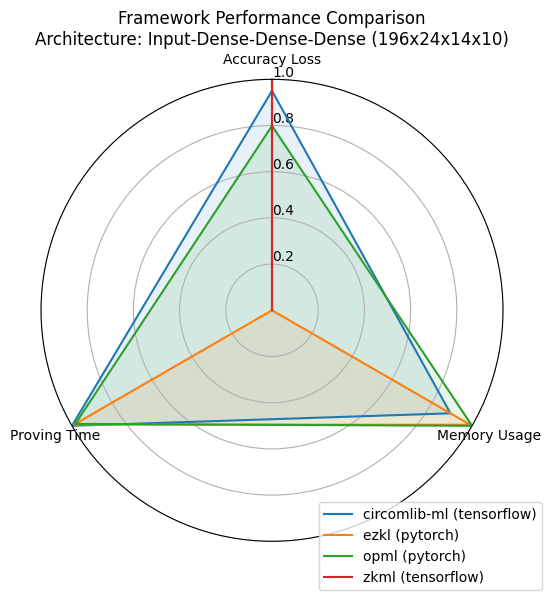

In [14]:
plot_radar_arch(transition_data, architectures[1], architectures)

### Varing Param in DNN

In [41]:
architectures = [target_arch(ori_models_list[1]), target_arch(ori_models_list[0])]
data = read_data_for_architectures('./dnn_param.csv', architectures)
frameworks, accuracy_loss, memory_usage, proving_time = extract(data, architectures)


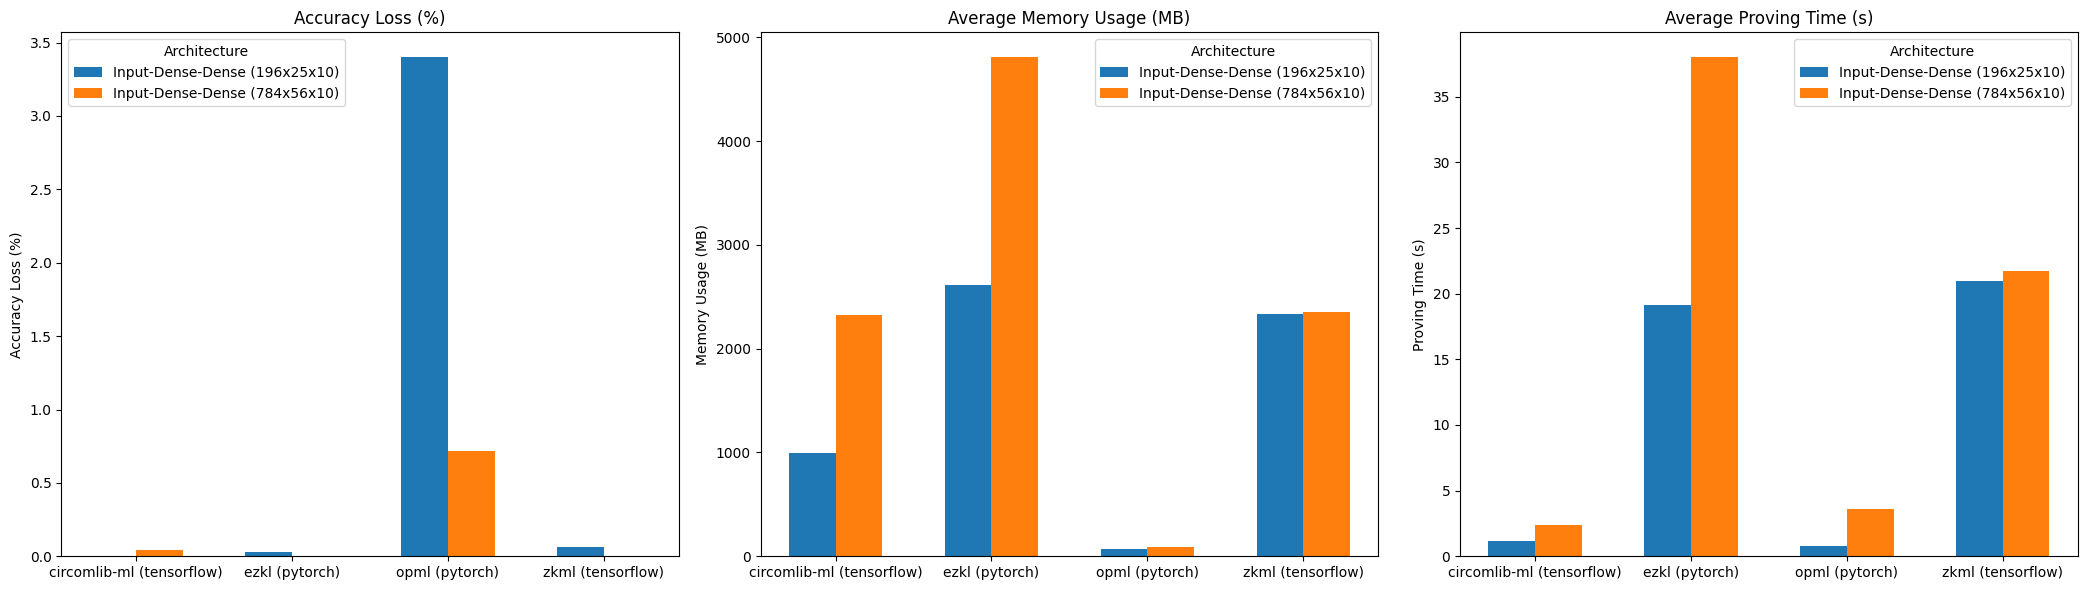

In [42]:
plot_bar(architectures, frameworks, accuracy_loss, memory_usage, proving_time)

In [43]:
transition_data = prepare_radar_data(architectures, frameworks, accuracy_loss, memory_usage, proving_time)

Ranking for Input-Dense-Dense (196x25x10):
  1. circomlib-ml (tensorflow) with a score of 2.6173363232334004
  2. opml (pytorch) with a score of 2.0
  3. zkml (tensorflow) with a score of 1.0944148588787939
  4. ezkl (pytorch) with a score of 1.0837361648756627

Ranking for Input-Dense-Dense (784x56x10):
  1. circomlib-ml (tensorflow) with a score of 2.469842543641066
  2. zkml (tensorflow) with a score of 1.9762750696290319
  3. opml (pytorch) with a score of 1.9647022527764664
  4. ezkl (pytorch) with a score of 1.0



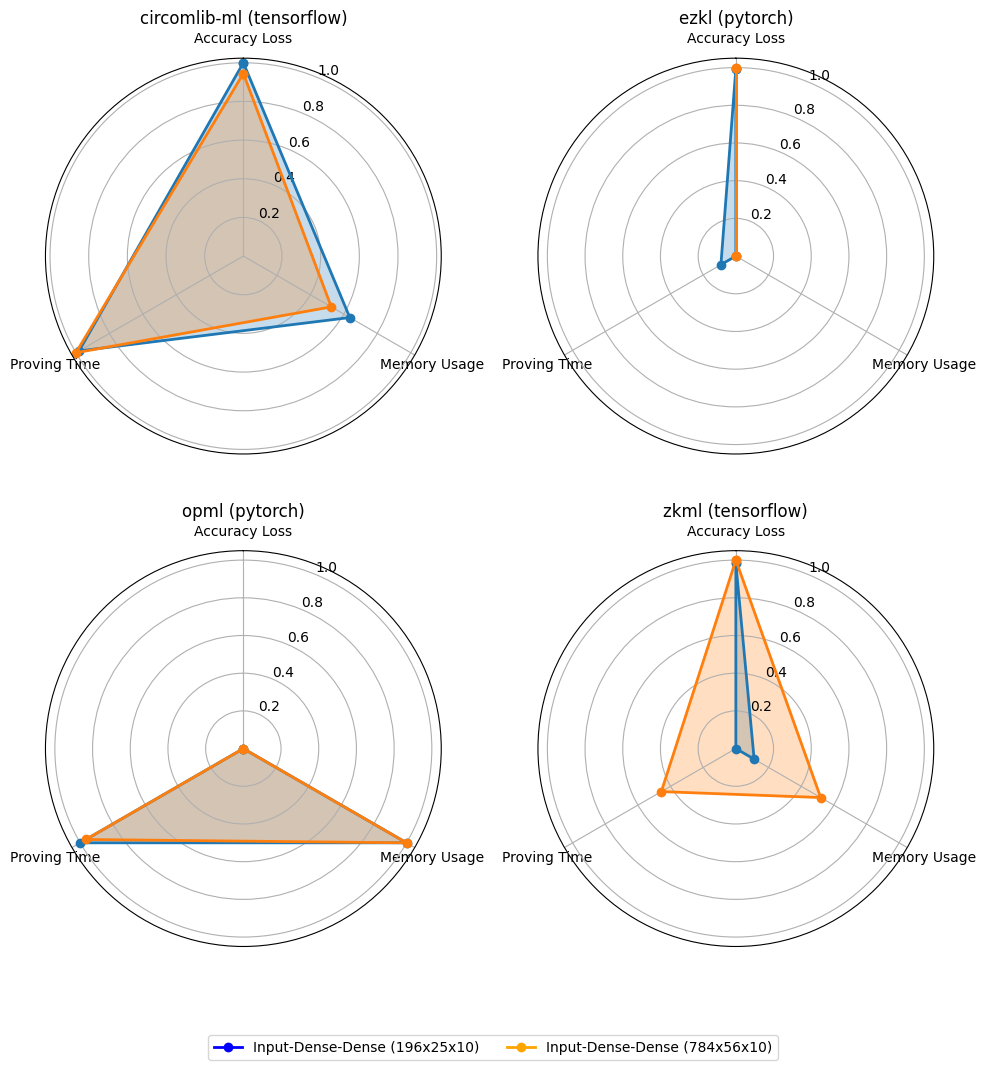

In [44]:
plot_radar_trans(architectures, transition_data)

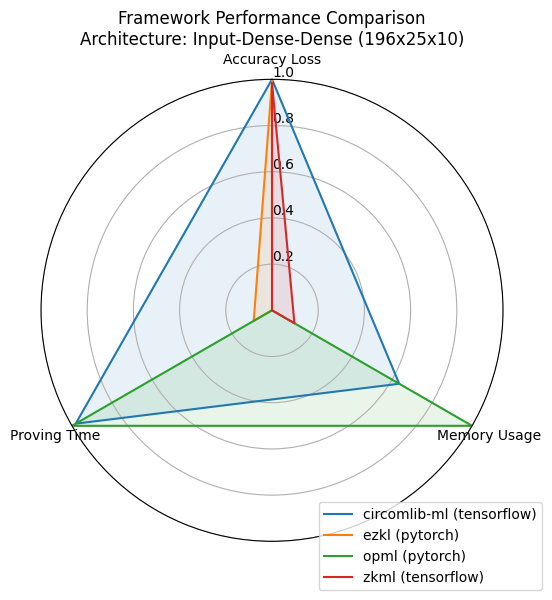

In [45]:
plot_radar_arch(transition_data, architectures[0], architectures)

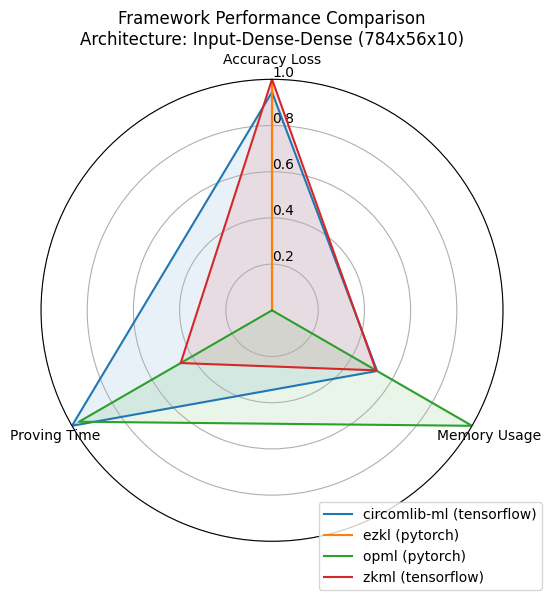

In [26]:
plot_radar_arch(transition_data, architectures[1], architectures)

## CNN

### Varying Arch of CNN 

In [29]:
architectures = [target_arch(ori_models_list[4]), target_arch(ori_models_list[3])]
data = read_data_for_architectures('./cnn_layer.csv', architectures)
frameworks, accuracy_loss, memory_usage, proving_time = extract(data, architectures)


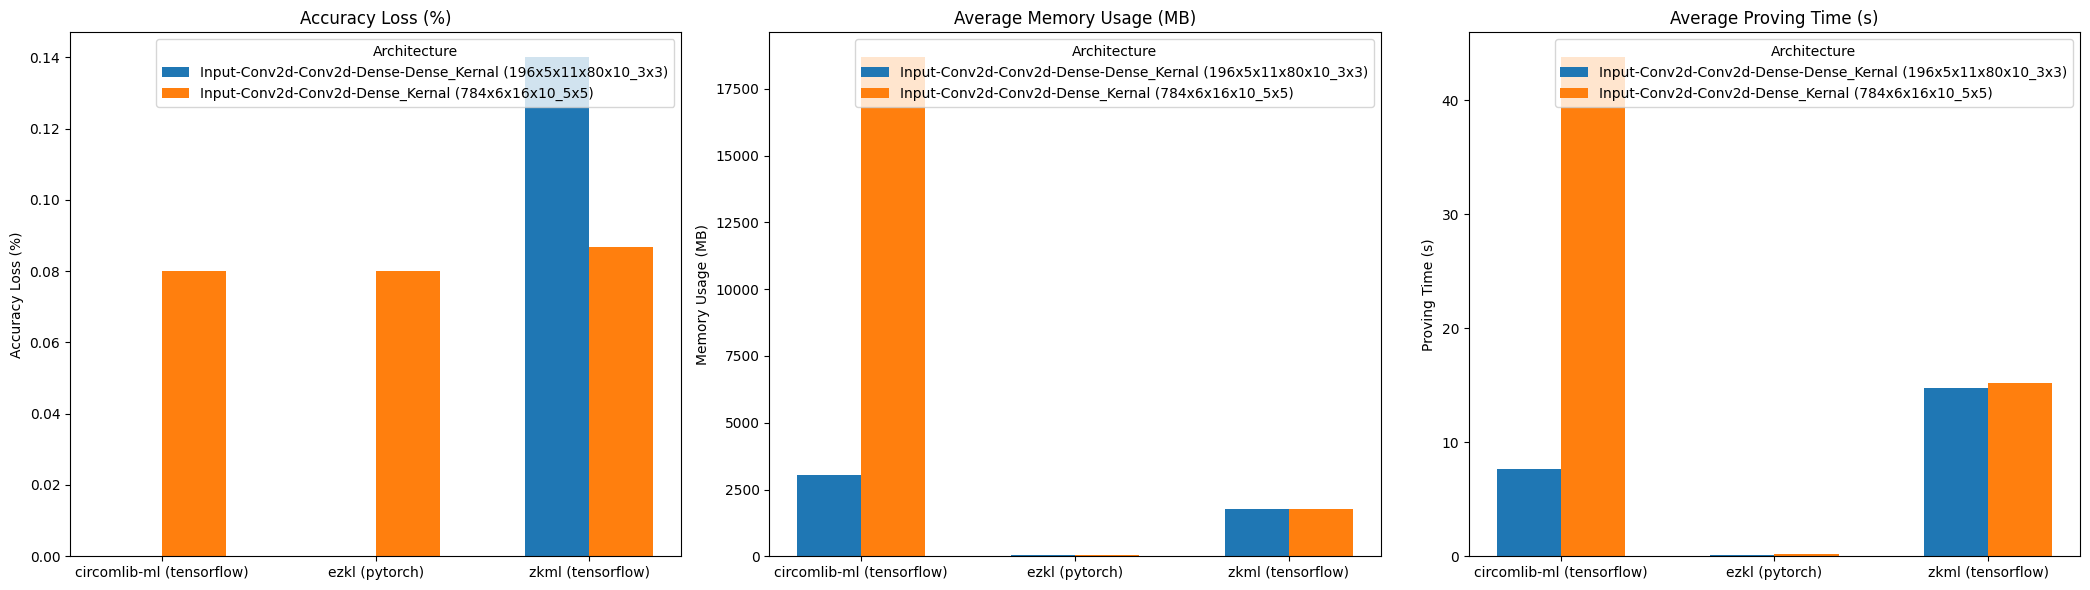

In [30]:
plot_bar(architectures, frameworks, accuracy_loss, memory_usage, proving_time)

In [31]:
transition_data = prepare_radar_data(architectures, frameworks, accuracy_loss, memory_usage, proving_time)

Ranking for Input-Conv2d-Conv2d-Dense-Dense_Kernal (196x5x11x80x10_3x3):
  1. ezkl (pytorch) with a score of 3.0
  2. circomlib-ml (tensorflow) with a score of 1.4875524332179872
  3. zkml (tensorflow) with a score of 0.43097688786553373

Ranking for Input-Conv2d-Conv2d-Dense_Kernal (784x6x16x10_5x5):
  1. ezkl (pytorch) with a score of 3.0
  2. zkml (tensorflow) with a score of 1.5628880491345807
  3. circomlib-ml (tensorflow) with a score of 1.0



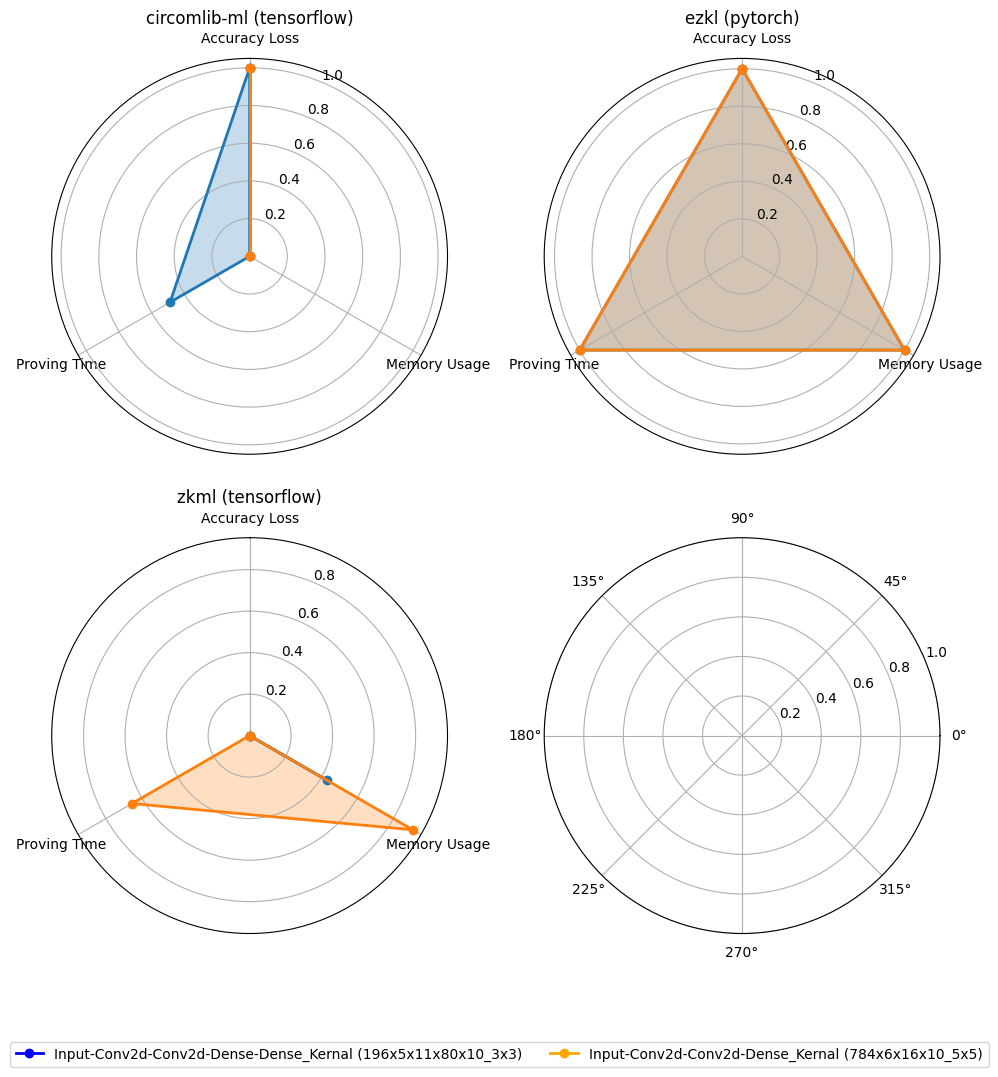

In [32]:
plot_radar_trans(architectures, transition_data)

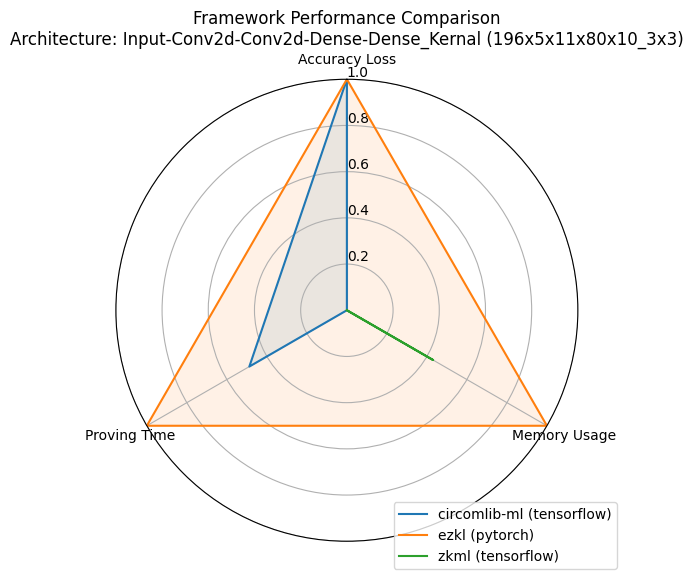

In [33]:
plot_radar_arch(transition_data, architectures[0], architectures)

### Adding Extra Dense Layers

In [21]:
architectures = [target_arch(ori_models_list[3]), target_arch(ori_models_list[5])]
data = read_data_for_architectures('./cnn_ext_dense.csv', architectures)
frameworks, accuracy_loss, memory_usage, proving_time = extract(data, architectures)

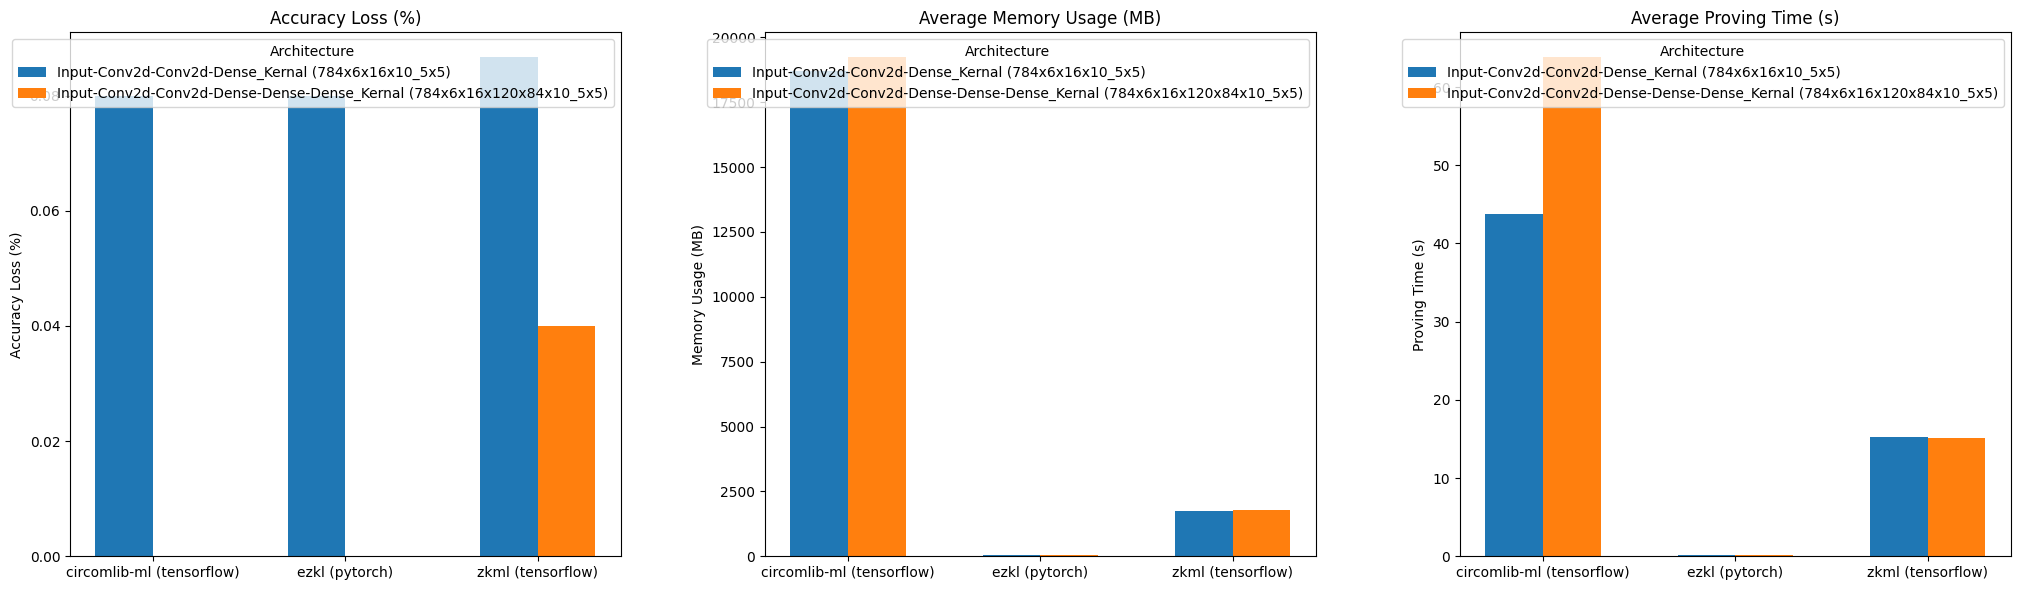

In [22]:
plot_bar(architectures, frameworks, accuracy_loss, memory_usage, proving_time)

In [23]:
transition_data = prepare_radar_data(architectures, frameworks, accuracy_loss, memory_usage, proving_time)

Ranking for Input-Conv2d-Conv2d-Dense_Kernal (784x6x16x10_5x5):
  1. ezkl (pytorch) with a score of 3.0
  2. zkml (tensorflow) with a score of 1.5628880491345807
  3. circomlib-ml (tensorflow) with a score of 1.0

Ranking for Input-Conv2d-Conv2d-Dense-Dense-Dense_Kernal (784x6x16x120x84x10_5x5):
  1. ezkl (pytorch) with a score of 3.0
  2. zkml (tensorflow) with a score of 1.6769818821334388
  3. circomlib-ml (tensorflow) with a score of 1.0



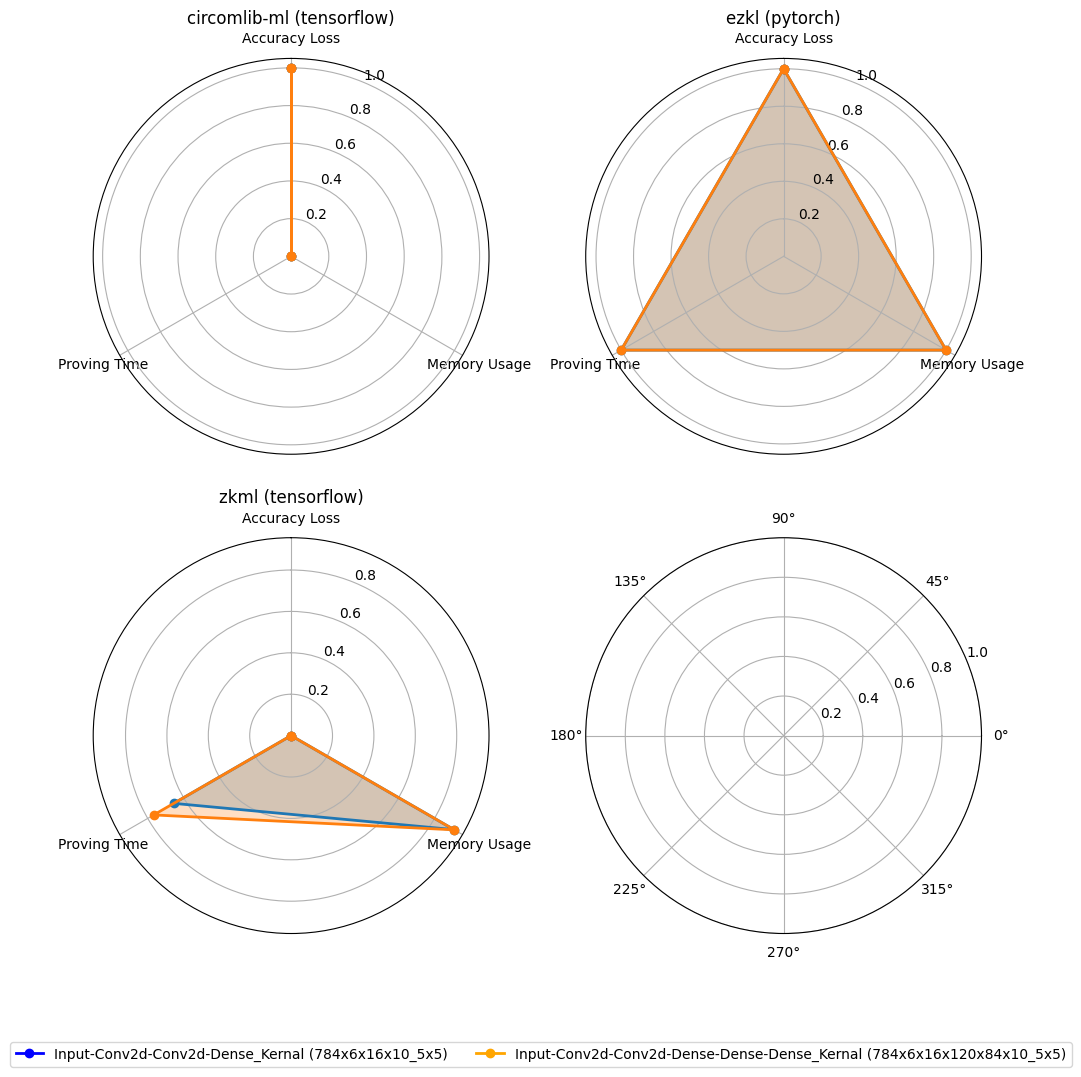

In [24]:
plot_radar_trans(architectures, transition_data)

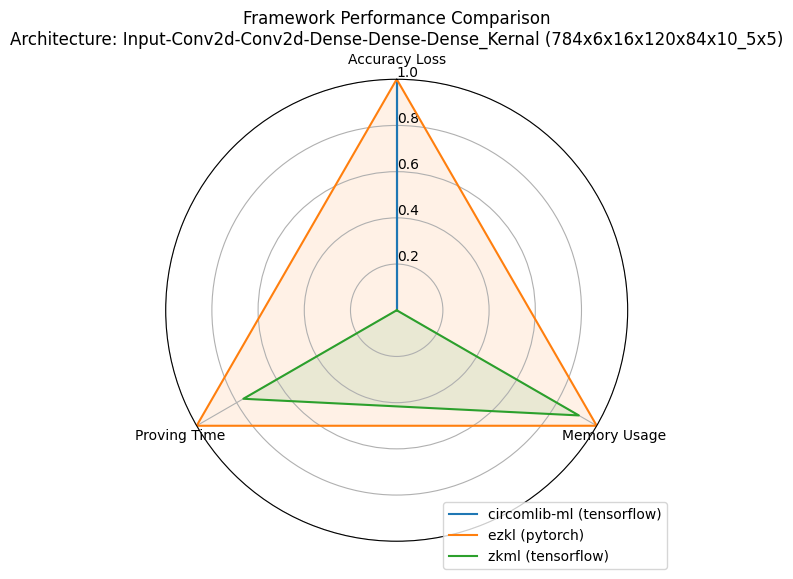

In [25]:
plot_radar_arch(transition_data, architectures[1], architectures)

### Varying Layer of DNN-CNN with same # of layer

### Varying Layer of DNN-CNN with same # of layer 2

In [26]:
ori_models_list

['784_56_10',
 '196_25_10',
 '196_24_14_10',
 '28_6_16_10_5',
 '14_5_11_80_10_3',
 '28_6_16_120_84_10_5']

In [35]:
architectures = [target_arch(ori_models_list[5]), target_arch(ori_models_list[0])]
data = read_data_for_architectures('./cnn_dnn_.csv', architectures)
frameworks, accuracy_loss, memory_usage, proving_time = extract(data, architectures)

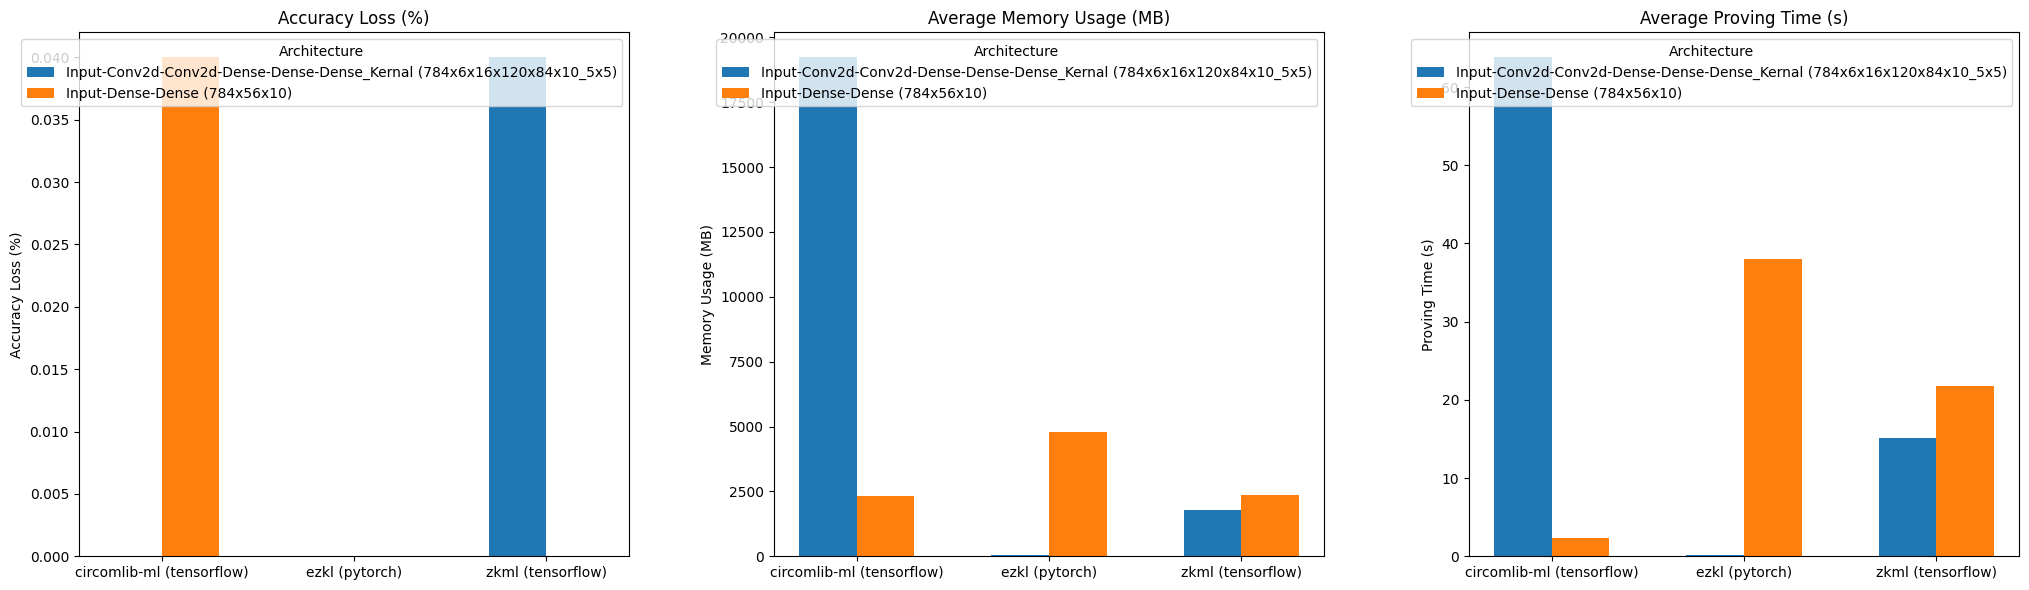

In [36]:
plot_bar(architectures, frameworks, accuracy_loss, memory_usage, proving_time)

In [37]:
transition_data = prepare_radar_data(architectures, frameworks, accuracy_loss, memory_usage, proving_time)

Ranking for Input-Conv2d-Conv2d-Dense-Dense-Dense_Kernal (784x6x16x120x84x10_5x5):
  1. ezkl (pytorch) with a score of 3.0
  2. zkml (tensorflow) with a score of 1.6769818821334388
  3. circomlib-ml (tensorflow) with a score of 1.0

Ranking for Input-Dense-Dense (784x56x10):
  1. zkml (tensorflow) with a score of 2.445760489919883
  2. circomlib-ml (tensorflow) with a score of 2.0
  3. ezkl (pytorch) with a score of 1.0



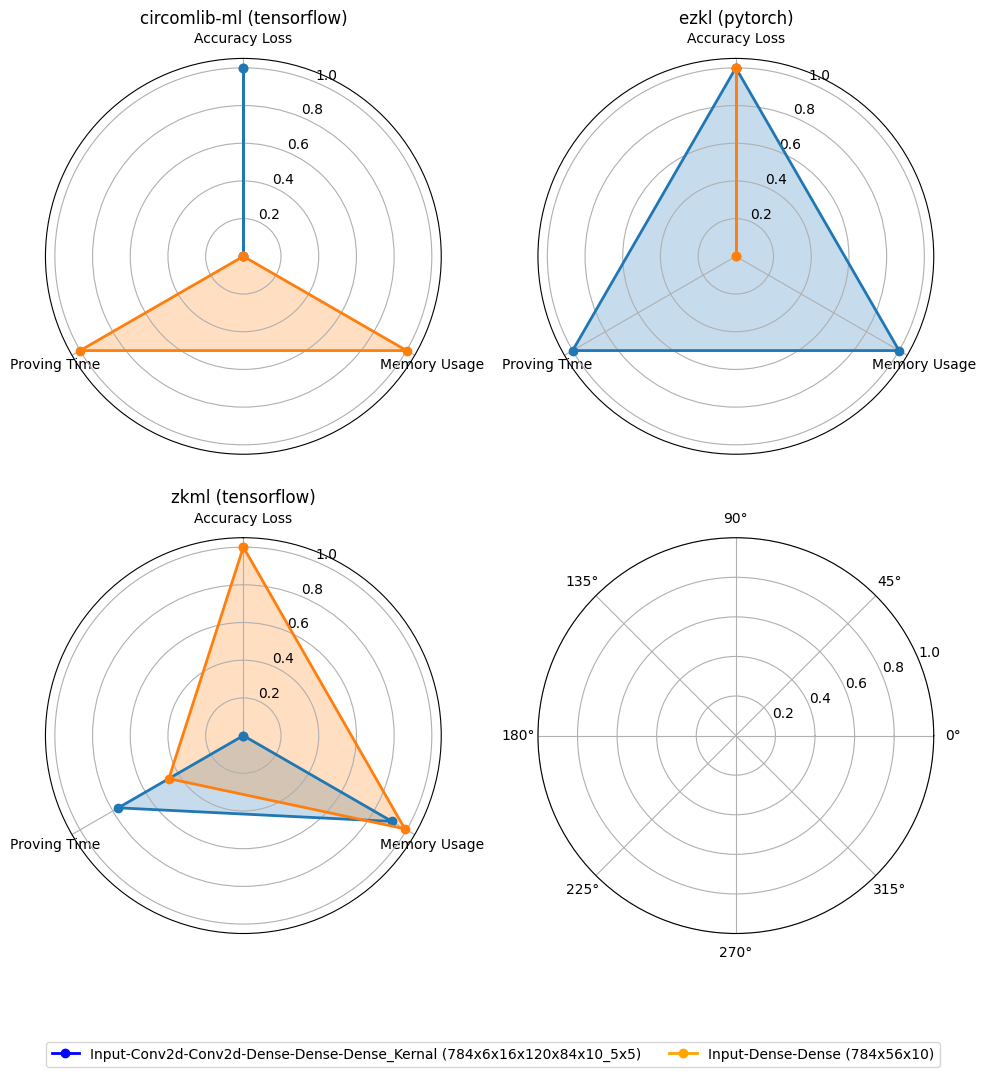

In [38]:
plot_radar_trans(architectures, transition_data)

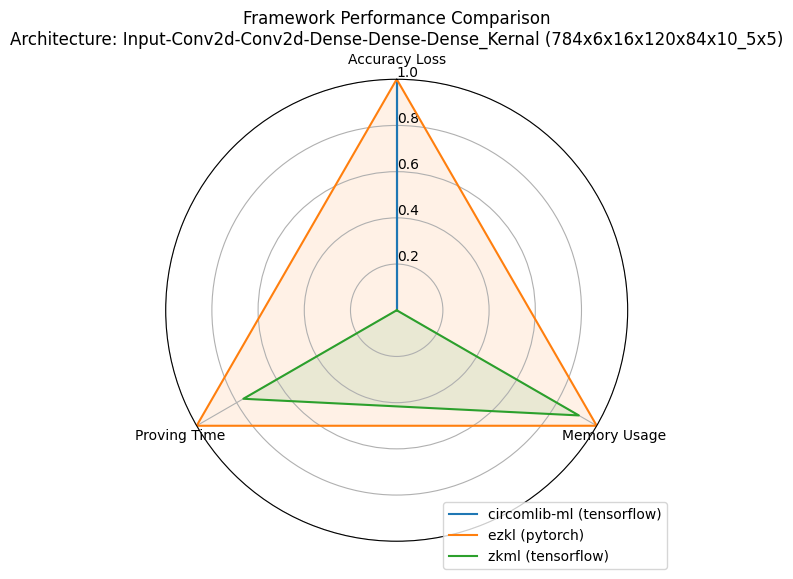

In [34]:
plot_radar_arch(transition_data, architectures[0], architectures)

In [34]:
architectures = [target_arch(ori_models_list[3]), target_arch(ori_models_list[2])]
data = read_data_for_architectures('./cnn_dnn.csv', architectures)
frameworks, accuracy_loss, memory_usage, proving_time = extract(data, architectures)

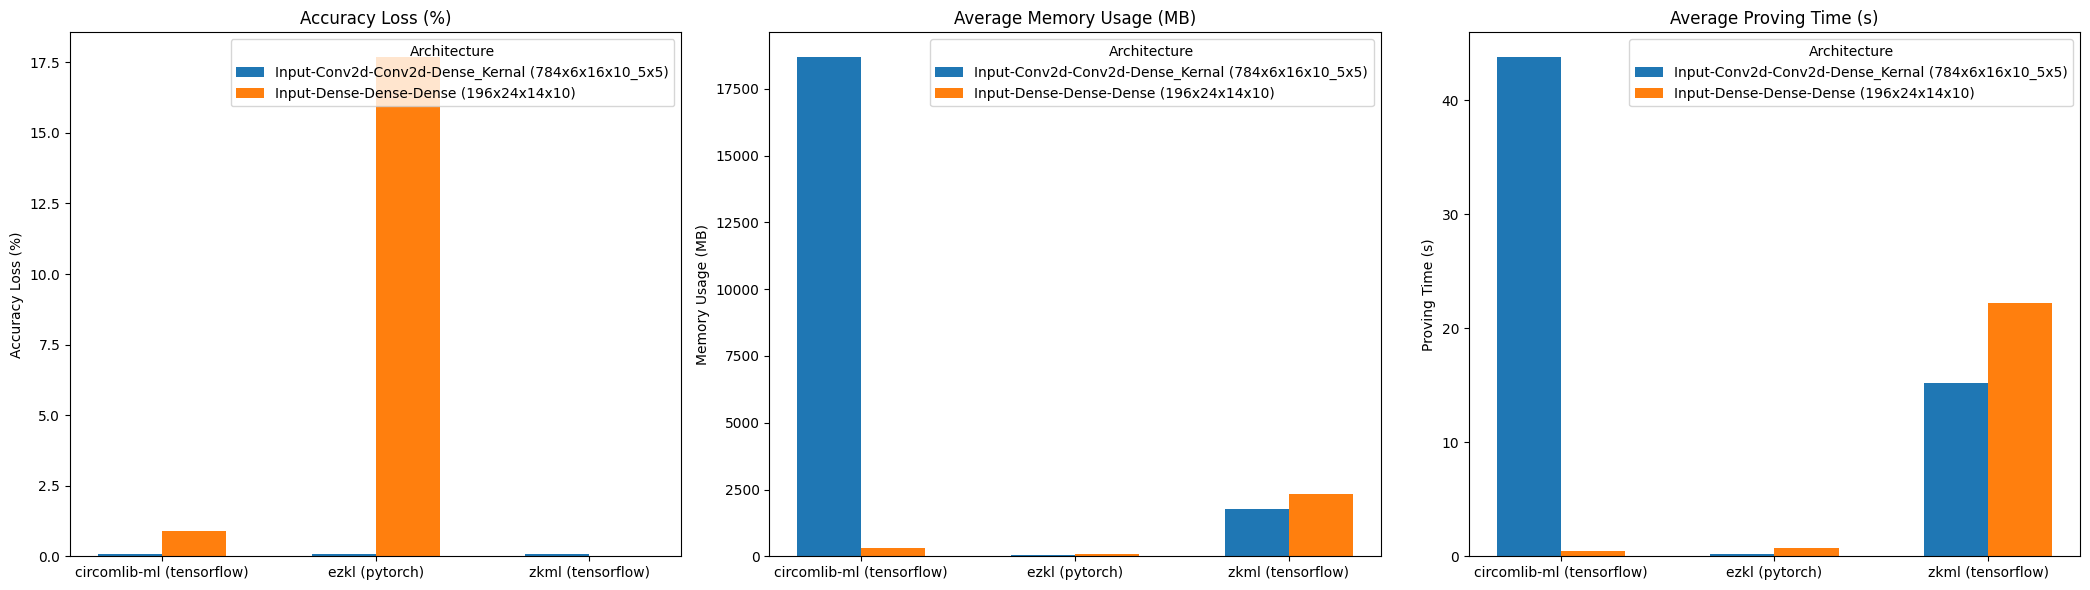

In [35]:
plot_bar(architectures, frameworks, accuracy_loss, memory_usage, proving_time)

In [36]:
transition_data = prepare_radar_data(architectures, frameworks, accuracy_loss, memory_usage, proving_time)

Ranking for Input-Conv2d-Conv2d-Dense_Kernal (784x6x16x10_5x5):
  1. ezkl (pytorch) with a score of 3.0
  2. zkml (tensorflow) with a score of 1.5628880491345807
  3. circomlib-ml (tensorflow) with a score of 1.0

Ranking for Input-Dense-Dense-Dense (196x24x14x10):
  1. circomlib-ml (tensorflow) with a score of 2.8503668997135163
  2. ezkl (pytorch) with a score of 1.9892746198635494
  3. zkml (tensorflow) with a score of 1.0



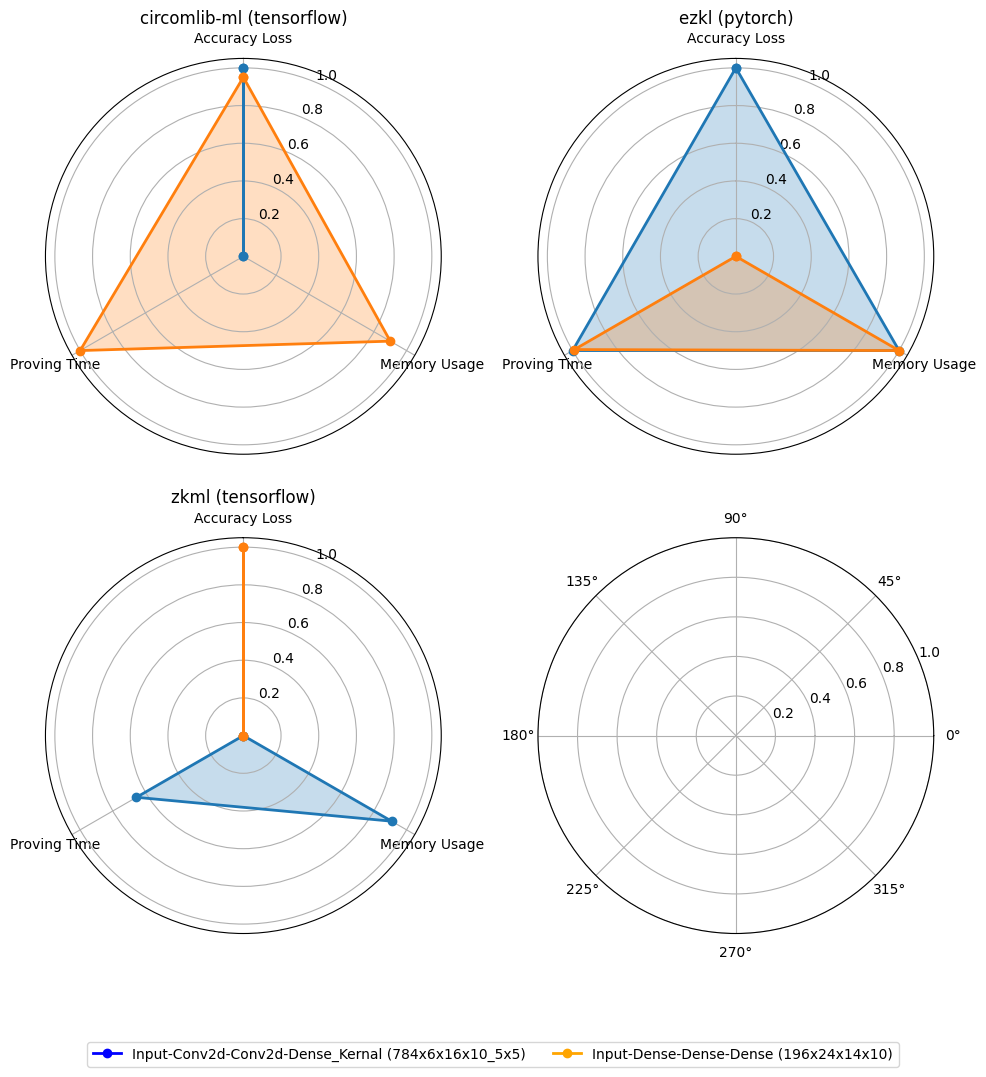

In [37]:
plot_radar_trans(architectures, transition_data)

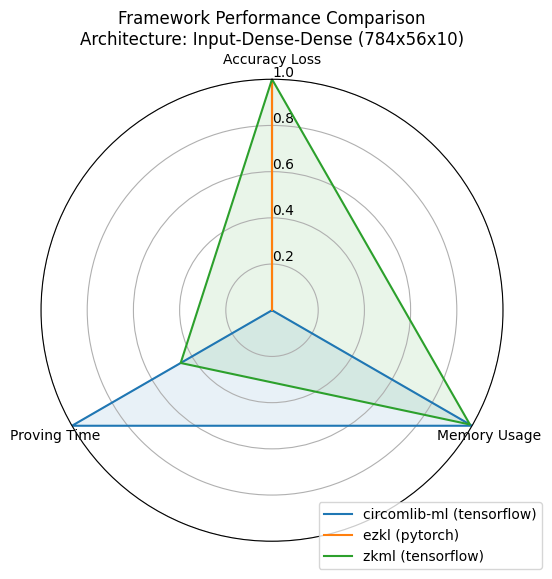

In [39]:
plot_radar_arch(transition_data, architectures[1], architectures)